<a href="https://colab.research.google.com/github/nataliasc/dyadicdecisionmaking/blob/2ifc-random-dots/dataanalysis/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Run the following in the order stated below before this script**


1.   post_experiment for every experiment_pair. Ideally this was done already after every experiment for first level checks.
2.   fit_hddm (to have the parameter estimate of each subject for various conditions)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set up

In [1]:
!pip install scipy==1.7.1

     |████████████████████████████████| 28.5 MB 1.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
!pip install bambi

     |████████████████████████████████| 72 kB 1.0 MB/s 
     |████████████████████████████████| 43 kB 1.5 MB/s 


In [3]:
import arviz as az
import bambi
import glob
import matplotlib
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy
import seaborn as sns
from scipy.special import erfcinv
import statsmodels
sns.set_palette("Accent")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Part A: Is there a choice history bias in dyadic trials?


Objectives: Test the hypothesis of choice history bias from dyadic interaction and characterise the nature of the bias.

Assumes: Choice history bias after own trials

Answers the questions:
1.   Is there a history bias if the previous trial is done by the partner?



    
    



In [4]:
#calculates dprime given dataframe of a subject's response
#filter for na when calculating p(repeat)

def dprime(df):
    """
    left (-1): signal present
    right (1) : signal absent
    """
    d = 0
    c = 0
    
    #calculate hit rate,HR and false alarm rate, FA
    signal = df[df['direction'] == -1].shape[0]
    nosignal = df[df['direction'] == 1].shape[0]

    hits = df[(df['direction'] == -1) & (df['response'] == -1)].shape[0]
    falsealarms = df[(df['direction'] == 1) & (df['response'] == -1)].shape[0]
    try:
        hit_rate = hits/signal
        fa_rate = falsealarms/nosignal

        if not (0 <= hit_rate <= 1 and 0 <= fa_rate <= 1):
            print("Hit Rate and/or False Alarm Rate out of range")

        if hit_rate > 0:
            hit_rate = min(hit_rate, 1 - 0.5/signal)
        else:
            hit_rate = 0.5/signal

        if fa_rate < 1:
            fa_rate = max(fa_rate, 0.5/nosignal)
        else:
            fa_rate = 1 - 0.5/nosignal

        zHit = -sqrt(2) * erfcinv(2 * hit_rate)
        zFA = -sqrt(2) * erfcinv(2 * fa_rate)

        d = zHit - zFA
        c = - 0.5 * (zHit + zFA)
    except Exception as e:
        print("Couldnt determine dprime and criterion. {}".format(e))
        
     
    return d,c

In [5]:
"""
Prepare for running
Combine data of all pairs if not done already
NOTE: If the combined file doesnt already exist it indicates that fit_HDDM wasnt done. Do that first. 
"""
datasrc = "drive/MyDrive/DDM_SP_2021-22/data/coded"
plotfolder = "drive/MyDrive/DDM_SP_2021-22/data/plots"
datafile = "all_trials_data.csv"

#if the concatenated data from each experimnetal run exists, use that, else create the concatenated data first
data_loc = os.path.join(datasrc,datafile)
if os.path.exists(data_loc):
    trials_df = pd.read_csv(data_loc)
    print("Concatenated datafile with full experiment data found and loaded")
else:
    files = glob.glob(os.path.join(datasrc,'pair*.csv'))
    mydata = pd.concat([pd.read_csv(f) for f in files ])
    mydata.to_csv(data_loc,index=False,header=True)
    print("Concatenated datafile with full experiment data at --> {}".format(data_loc))
    trials_df = pd.read_csv(data_loc)
    

prev_trials_window = 1 #shouldnt be more the parameter value in the post_experiment script

Concatenated datafile with full experiment data found and loaded


In [8]:
#for better looking charts, subject ids are shorterned
subjects = trials_df['subj_idx'].unique()
sids = {x: 's' + str(i+1) for i,x in enumerate(trials_df['subj_idx'].unique())}
"""
for c in trials_df.columns:
  if ('subj' in c ) or ('subject' in c ):
    trials_df[c].replace(sids,inplace=True)
"""
sids


{'268006_1': 's2',
 '268006_2': 's1',
 '280933_1': 's3',
 '280933_2': 's4',
 '476030_1': 's5',
 '476030_2': 's6',
 '659640_1': 's7',
 '659640_2': 's8',
 '725232_1': 's9',
 '725232_2': 's10',
 '754128_1': 's11',
 '754128_2': 's12',
 '812810_1': 's13',
 '812810_2': 's14',
 '897304_1': 's16',
 '897304_2': 's15',
 '900778_1': 's17',
 '900778_2': 's18',
 '958733_1': 's20',
 '958733_2': 's19'}

***************Accurcay Rate****************
Overall              mean: 77.55% sem: 2.73%
After Own trial,     mean: 76.87% sem: 2.77%
After Partner trial, mean: 78.26% sem: 2.80%



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


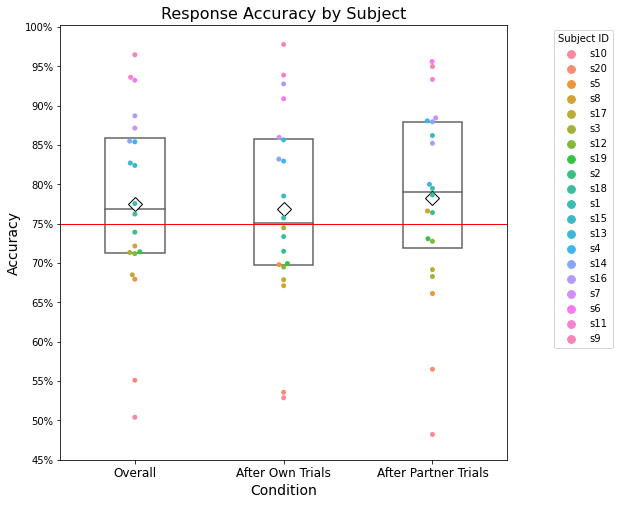

In [ ]:
"""
Summary: Accuracy Rates
"""
t1 = trials_df.groupby(['subj_idx'])['correct'].mean().rename('Overall')
t2 = trials_df[trials_df['subj_idx'] != trials_df['l1_subject']].groupby(['subj_idx'])['correct'].mean().rename('After Partner Trials')
t3 = trials_df[trials_df['subj_idx'] == trials_df['l1_subject']].groupby(['subj_idx'])['correct'].mean().rename('After Own Trials')
print('{:*^44s}'.format('Accurcay Rate'))
print("{:20s} mean: {:5.2%} sem: {:5.2%}".format('Overall',t1.mean(),scipy.stats.sem(t1)))
print("{:20s} mean: {:5.2%} sem: {:5.2%}".format('After Own trial,',t3.mean(),scipy.stats.sem(t3)))
print("{:20s} mean: {:5.2%} sem: {:5.2%}\n".format('After Partner trial,',t2.mean(),scipy.stats.sem(t2)))
accuracy = pd.concat([t1, t2,t3], axis=1, join="outer")
accuracy = accuracy.stack().reset_index(name='accuracy').sort_values(by='accuracy')
accuracy['subj_idx'].replace(sids,inplace=True) #change subject ids
order = ['Overall','After Own Trials','After Partner Trials']
fig, ax = plt.subplots(figsize=(8,8))
sns.swarmplot(data=accuracy,x='level_1',y='accuracy',hue='subj_idx',
              order=order,ax=ax)

sns.boxplot(data=accuracy,x='level_1',y='accuracy', order=order,width=0.4,
                 showcaps=False,boxprops={'facecolor':'None'},
                 showfliers=False,whiskerprops={'linewidth':0},
                 showmeans=True,
                 meanprops={"marker":"D",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
                 ax=ax)

"""
ax.errorbar(x=order, y=[t1.mean(),t3.mean(),t2.mean()], 
            yerr=[scipy.stats.sem(t1),scipy.stats.sem(t3),scipy.stats.sem(t2)], 
            capsize=None, color='black', alpha=1, linewidth=2, linestyle='', marker='o')
"""

ax.set_yticks(np.linspace(0.45,1,12))
ax.set_yticklabels(['{:3.0%}'.format(x) for x in ax.get_yticks()])
ax.tick_params(axis='x', which='major', labelsize=12)
ax.set_ylabel("Accuracy",fontsize=14)
ax.set_xlabel("Condition",fontsize=14)
ax.legend(title="Subject ID", bbox_to_anchor=(1.25, 1.0))
ax.axhline(0.75,color='r',linewidth=1)
ax.set_title("Response Accuracy by Subject",fontsize=16)
plt.savefig(os.path.join(plotfolder,"accuracy.eps"),dpi=1200)
plt.show()

In [ ]:
#bnasic assumption in analysis: each individual is independent..resample individuals
tmpdf = pd.concat([t1, t2,t3], axis=1, join="outer")
tmpdf['diff'] = tmpdf['After Partner Trials'] - tmpdf['After Own Trials']
tmpdf = tmpdf['diff']
ci = scipy.stats.bootstrap((tmpdf.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=-0.0081452031774627, high=0.032995827623636106)


**Accuracy in trials after own trial and after partner trials arent different**

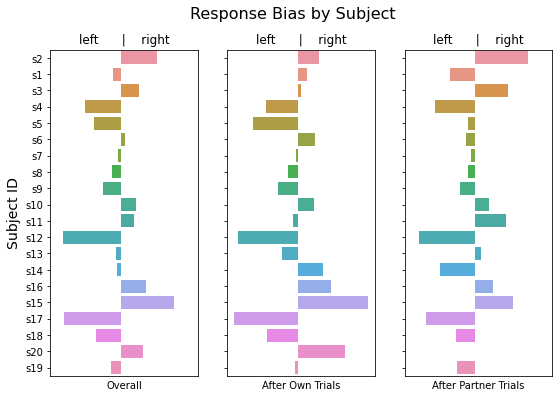

In [ ]:
"""
Summary: Response direction bias 
"""
fig, ax = plt.subplots(1,3,figsize=(9,6),sharey=True,sharex=True)
tmpdf = trials_df.groupby(['subj_idx'])['response'].mean().rename('Overall')
tmpdf.rename(index=sids,inplace=True)#change subject ids
sns.barplot(x=tmpdf,y=tmpdf.index,ax=ax[0])

tmpdf = trials_df[trials_df['subj_idx'] == trials_df['l1_subject']].groupby(['subj_idx'])['response'].mean().rename('After Own Trials')
tmpdf.rename(index=sids,inplace=True)#change subject ids
sns.barplot(x=tmpdf,y=tmpdf.index,ax=ax[1])

tmpdf = trials_df[trials_df['subj_idx'] != trials_df['l1_subject']].groupby(['subj_idx'])['response'].mean().rename('After Partner Trials')
tmpdf.rename(index=sids,inplace=True)#change subject ids
sns.barplot(x=tmpdf,y=tmpdf.index,ax=ax[2])

for i in range(3):
  ax[i].set_title("left      |    right",fontsize=12)
  ax[i].set_xticks([])
ax[0].set_ylabel('Subject ID',fontsize=14)
ax[1].set_ylabel('')
ax[2].set_ylabel('')

plt.suptitle("Response Bias by Subject",fontsize=16)
plt.savefig(os.path.join(plotfolder,"responsebias.eps"),dpi=1200)
plt.show()
del tmpdf

In [ ]:
def det_behavior(x):
  if x[0] >= 0.5:
    if x[1] >= 0.5:
      return 'Stay'
    else:
      return ('Win Switch')
  else:
    if x[1] >= 0.5:
      return 'Win Stay'
    else:
      return 'Switch'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


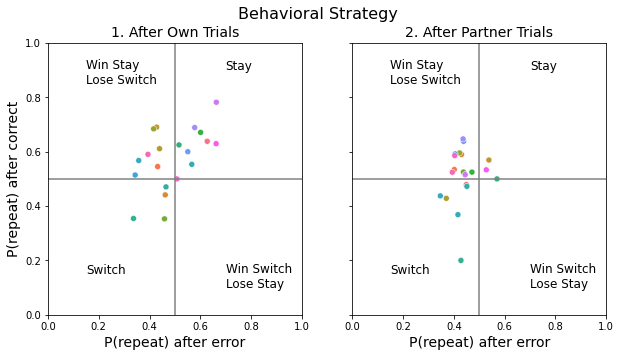

In [ ]:
"""
Summary: Bahavioral Strategies
"""
tmpdf = trials_df[['subj_idx','l1_subject','l1_stim', 'l1_resp','l1_repeat']]
tmpdf['l1_correct'] = (tmpdf['l1_stim'] == tmpdf['l1_resp']) * 1
tmpdf['l1_subject'] = np.select([(tmpdf['subj_idx'] == tmpdf['l1_subject']),(tmpdf['subj_idx'] != tmpdf['l1_subject'])],['Own','Partner'])
tmpdf = tmpdf.groupby(['subj_idx','l1_subject','l1_correct'])['l1_repeat'].mean().unstack()
tmpdf['behav'] = tmpdf.apply(lambda x: det_behavior(x),axis=1)

fig,ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
fig.suptitle("Behavioral Strategy",fontsize=16)
for i,val in enumerate(['Own','Partner']):
  d = tmpdf.xs(val, level='l1_subject')
  sns.scatterplot(x=d[1],y=d[0],hue=d.index,legend=False,ax=ax[i])
  ax[i].set_title('{}. After {} Trials'.format(i+1,val),fontsize=14)
  ax[i].axvline(0.5,color='gray')
  ax[i].axhline(0.5,color='gray')
  ax[i].set_xlim(0,1)
  ax[i].set_xlabel("P(repeat) after error",fontsize=14)
  ax[i].set_ylim(0,1)
  ax[i].set_ylabel("P(repeat) after correct",fontsize=14)
  ax[i].text(0.7, 0.9,'Stay', fontsize=12)
  ax[i].text(0.15, 0.85,"Win Stay\nLose Switch", fontsize=12)
  ax[i].text(0.15, 0.15,"Switch", fontsize=12)
  ax[i].text(0.7, 0.10,"Win Switch\nLose Stay", fontsize=12)

plt.savefig(os.path.join(plotfolder,"behavstrat.eps"),dpi=1200)
plt.show()

del tmpdf

In [6]:
#get Gsquare fit retults for the prevcorrect condition
gsq_data = pd.read_csv("drive/MyDrive/DDM_SP_2021-22/data/output/stimcoding_dc_z_prevcorrect_dyadic_l1/Gsquare.csv")
gsq_data['z_shift_prevcorrect_own'] = gsq_data['z(0.1.0.own)'] - gsq_data['z(1.1.0.own)'] #left,correct - right,correct
gsq_data['z_shift_prevcorrect_dyad'] = gsq_data['z(0.1.0.partner)'] - gsq_data['z(1.1.0.partner)'] #left,correct - right,correct
gsq_data['z_shift_preverr_own'] = gsq_data['z(0.0.0.own)'] - gsq_data['z(1.0.0.own)'] #left,err- right,err
gsq_data['z_shift_preverr_dyad'] = gsq_data['z(0.0.0.partner)'] - gsq_data['z(1.0.0.partner)'] #left,err - right,err
gsq_data['v_shift_prevcorrect_own'] = gsq_data['dc(0.1.0.own)'] - gsq_data['dc(1.1.0.own)'] #left,correct - right,correct
gsq_data['v_shift_prevcorrect_dyad'] = gsq_data['dc(0.1.0.partner)'] - gsq_data['dc(1.1.0.partner)'] #left,correct - right,correct
gsq_data['v_shift_preverr_own'] = gsq_data['dc(0.0.0.own)'] - gsq_data['dc(1.0.0.own)'] #left,err - right,err
gsq_data['v_shift_preverr_dyad'] = gsq_data['dc(0.0.0.partner)'] - gsq_data['dc(1.0.0.partner)'] #left,err- right,err
gsq_data = gsq_data[['subj_idx','z_shift_prevcorrect_own','z_shift_prevcorrect_dyad','z_shift_preverr_own','z_shift_preverr_dyad','v_shift_prevcorrect_own','v_shift_prevcorrect_dyad','v_shift_preverr_own','v_shift_preverr_dyad']]



In [9]:
individual_data = []
hddm_data = pd.read_csv("drive/MyDrive/DDM_SP_2021-22/data/output/stimcoding_dc_z_resp_dyadic_l1/results-combined.csv",index_col=0)
nohist = pd.read_csv("drive/MyDrive/DDM_SP_2021-22/data/output/stimcoding_nohist/results-combined.csv",index_col=0)
for sid in subjects:
    tmpdict = {}
    tmpdict['subj_idx'] = sid
    tmpdf = trials_df[trials_df['subj_idx'] == sid]
    tmpdict['dprime'], tmpdict['criterion'] = dprime(tmpdf[['direction','response']])
    tmpdict['v'] = nohist.loc["v_subj." + sid,'mean']
    tmpdict['accuracy'] = tmpdf['correct'].mean()
    tmpdict['rt'] = tmpdf['rt'].median()
    tmpdict['bias'] = tmpdf['response'].mean()
    for n in range(1,prev_trials_window + 1):
        prefix = 'l' + str(n) + '_' #prefix for the column name
        col_stim = prefix + 'stim'
        tmpdf[prefix + 'correct'] = (tmpdf[prefix + 'stim'] == tmpdf[prefix + 'resp']) * 1
        tmpdict[prefix + 'correct'] = tmpdf[prefix + 'correct'].mean()
        t = tmpdf[~tmpdf[col_stim].isna()] #filter out rows where stim is NaN
        tmpdict[prefix + 'pr'] = t[prefix + 'repeat'].mean()
        own = t[prefix + 'subject'] == sid
        tmpdict[prefix + 'pr_own'] = t.loc[own,prefix + 'repeat'].mean()
        tmpdict[prefix + 'pr_dyad'] = t.loc[~own,prefix + 'repeat'].mean()
        #prepeat after correct and error
        mask = (t[prefix + 'subject'] == sid) & (t[prefix + 'correct'] == 1)
        tmpdict[prefix + 'pr_post_corr_own']= t.loc[mask,prefix + 'repeat'].mean()
        mask = (t[prefix + 'subject'] == sid) & (t[prefix + 'correct'] == 0)
        tmpdict[prefix + 'pr_post_err_own']= t.loc[mask,prefix + 'repeat'].mean()
        mask = (t[prefix + 'subject'] != sid) & (t[prefix + 'correct'] == 1)
        tmpdict[prefix + 'pr_post_corr_dyad']= t.loc[mask,prefix + 'repeat'].mean()
        mask = (t[prefix + 'subject'] != sid) & (t[prefix + 'correct'] == 0)
        tmpdict[prefix + 'pr_post_err_dyad']= t.loc[mask,prefix + 'repeat'].mean()
        
        #prepeat after fast and slow
        fastRTs = t['rt'] < tmpdict['rt']
        slowRTs = t['rt'] > tmpdict['rt']
        
        tmpdict[prefix + 'pr_fastRT']= np.NaN
        tmpdict[prefix + 'pr_fastRT_own']= np.NaN
        tmpdict[prefix + 'pr_fastRT_dyad']= np.NaN
        tmpdict[prefix + 'pr_slowRT']= np.NaN
        tmpdict[prefix + 'pr_slowRT_own']= np.NaN
        tmpdict[prefix + 'pr_slowRT_dyad']= np.NaN
        
        if not fastRTs.empty:
            tmpdict[prefix + 'pr_fastRT']= t.loc[fastRTs,prefix + 'repeat'].mean()
            m1 = (t[prefix + 'subject'] == sid) & (t['rt'] < tmpdict['rt'])
            m2 = (t[prefix + 'subject'] != sid) & (t['rt'] < tmpdict['rt'])
            if not m1.empty:
                tmpdict[prefix + 'pr_fastRT_own']= t.loc[m1,prefix + 'repeat'].mean()
            if not m2.empty:
                tmpdict[prefix + 'pr_fastRT_dyad']= t.loc[m2,prefix + 'repeat'].mean()
        
        if not slowRTs.empty:
            tmpdict[prefix + 'pr_slowRT']= t.loc[slowRTs,prefix + 'repeat'].mean()
            m1 = (t[prefix + 'subject'] == sid) & (t['rt'] > tmpdict['rt'])
            m2 = (t[prefix + 'subject'] != sid) & (t['rt'] > tmpdict['rt'])
        if not m1.empty:
            tmpdict[prefix + 'pr_slowRT_own']= t.loc[m1,prefix + 'repeat'].mean()
        if not m2.empty:
            tmpdict[prefix + 'pr_slowRT_dyad']= t.loc[m2,prefix + 'repeat'].mean()

    #left minus right for DDM param estimates
    tmpdict['z_shift_own'] = hddm_data.loc["z_subj(0.0.own)." + sid,'mean'] - hddm_data.loc["z_subj(1.0.own)." + sid,'mean']
    tmpdict['z_shift_dyad'] = hddm_data.loc["z_subj(0.0.partner)." + sid,'mean'] - hddm_data.loc["z_subj(1.0.partner)." + sid,'mean']
    tmpdict['v_shift_own'] = hddm_data.loc["dc_subj(0.0.own)." + sid,'mean'] - hddm_data.loc["dc_subj(1.0.own)." + sid,'mean']
    tmpdict['v_shift_dyad'] = hddm_data.loc["dc_subj(0.0.partner)." + sid,'mean'] - hddm_data.loc["dc_subj(1.0.partner)." + sid,'mean']

        
    individual_data.append(tmpdict)

individual_df = pd.DataFrame(individual_data)
individual_df = individual_df.merge(gsq_data,how='inner',on='subj_idx')
display(individual_df)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

,subj_idx,dprime,criterion,v,accuracy,rt,bias,l1_correct,l1_pr,l1_pr_own,l1_pr_dyad,l1_pr_post_corr_own,l1_pr_post_err_own,l1_pr_post_corr_dyad,l1_pr_post_err_dyad,l1_pr_fastRT,l1_pr_fastRT_own,l1_pr_fastRT_dyad,l1_pr_slowRT,l1_pr_slowRT_own,l1_pr_slowRT_dyad,z_shift_own,z_shift_dyad,v_shift_own,v_shift_dyad,z_shift_prevcorrect_own,z_shift_prevcorrect_dyad,z_shift_preverr_own,z_shift_preverr_dyad,v_shift_prevcorrect_own,v_shift_prevcorrect_dyad,v_shift_preverr_own,v_shift_preverr_dyad
0,268006_2,1.514988,0.003252,1.109374,0.775561,0.863519,-0.032419,0.745636,0.452261,0.456311,0.447917,0.432099,0.545455,0.401460,0.563636,0.390000,0.434783,0.351852,0.517766,0.477876,0.571429,-0.006194,0.125518,0.492502,0.090451,0.093788,0.214569,0.157715,-0.100635,0.353409,0.217234,-1.171378,-1.667395
1,268006_1,1.283770,0.196323,1.048379,0.739241,0.673644,0.154430,0.759494,0.549872,0.630000,0.465969,0.627451,0.638298,0.448980,0.522727,0.576531,0.683673,0.469388,0.520619,0.578431,0.456522,-0.135281,0.065512,-0.542123,-0.052669,-0.097791,-0.052152,0.047364,-0.082145,0.831874,0.466164,-1.103561,0.156318
2,280933_1,1.153914,0.146230,0.800269,0.713402,1.078531,0.076289,0.779381,0.459459,0.456067,0.462810,0.461988,0.441176,0.429952,0.657143,0.413223,0.396947,0.432432,0.504202,0.523364,0.488550,0.109154,0.007388,0.001065,0.248419,-0.044350,-0.153862,0.022269,-0.060116,0.077546,0.654770,-0.202593,-0.809439
3,280933_2,2.406045,-0.483648,1.606729,0.854043,0.913661,-0.151874,0.775148,0.509921,0.469697,0.554167,0.427928,0.690476,0.538012,0.594203,0.496032,0.472441,0.520000,0.521912,0.463235,0.591304,0.004899,0.043663,0.578103,-0.096345,-0.134646,0.123370,0.073449,-0.227758,3.443406,0.432730,-1.571415,0.992926
4,476030_1,0.938869,-0.149438,0.643001,0.679513,0.967977,-0.111562,0.811359,0.438272,0.489796,0.385892,0.439306,0.611111,0.370044,0.642857,0.459016,0.557971,0.330189,0.414938,0.396226,0.429630,-0.016292,0.033536,0.211265,0.597223,-0.088010,0.273248,-0.133788,-0.200146,1.215237,-0.114483,-0.764487,-0.193909
5,476030_2,2.987074,0.034585,1.890234,0.932271,0.822678,0.015936,0.784861,0.462926,0.436508,0.489879,0.416309,0.684211,0.422360,0.616279,0.488000,0.481752,0.495575,0.437751,0.382609,0.485075,-0.130001,0.044415,0.823795,-0.109430,-0.279752,-0.047608,-0.021909,-0.046681,4.442150,0.783411,-1.254116,-0.251753
6,659640_1,2.270160,-0.048344,1.509401,0.871456,0.811110,-0.013233,0.824197,0.455238,0.446043,0.465587,0.459016,0.352941,0.437500,0.563636,0.452471,0.500000,0.404580,0.459770,0.400000,0.534483,-0.050829,0.115367,0.554672,0.128216,-0.051122,0.051051,0.078902,-0.088960,0.168175,0.292769,-1.356473,-0.118738
7,659640_2,1.174778,-0.041515,0.832342,0.721627,0.726120,-0.036403,0.751606,0.555315,0.625571,0.491736,0.601399,0.671053,0.471154,0.617647,0.549356,0.623853,0.483871,0.559471,0.623853,0.500000,-0.049182,0.086103,-0.588391,-0.231702,0.017424,-0.080649,0.007093,0.000880,0.747354,0.418304,-0.271265,-0.333682
8,725232_1,4.099362,-0.551058,3.472072,0.964623,0.644632,-0.075472,0.731132,0.528436,0.520000,0.538071,0.516129,0.625000,0.569892,0.509615,0.509434,0.523810,0.488372,0.547619,0.515152,0.576577,0.010506,0.029053,-0.186160,0.158792,0.136764,0.251001,-0.040836,-0.132619,-1.928754,-0.973727,-0.286370,-1.037615
9,725232_2,0.019072,0.077703,0.055490,0.504043,0.679856,0.061995,0.760108,0.384824,0.344828,0.420513,0.336842,0.354430,0.427807,0.250000,0.362162,0.305556,0.398230,0.409836,0.376238,0.451220,0.008699,0.046989,1.026907,0.467273,-0.014126,NaN,0.296397,-0.169449,0.391646,NaN,-9.339058,9.263122


In [ ]:
"""
Plots barplot and boxplot of features in adjacent columns
plot_types: The features on which plots are to be made n=len(plot_types)
plot_df: dataframe sorted by a key feature 
"""
def do_nx2_plots(plot_types,labels,suptitle,plot_df):
    fig, ax = plt.subplots(1, len(plot_types),figsize=(10,5))
    colors = {0:"olivedrab",1:"steelblue"}
    for idx,p in enumerate(plot_types):
        #sns.barplot(data=plot_df,x=p,y='subj_idx',ax=ax[idx][0])
        sns.barplot(data=plot_df,x=p,y='subj_idx',ax=ax[idx],color=colors[idx])
        ax[idx].axvline(plot_df[p].mean(), color='red',linestyle='--')
        #ax[idx][0].axvline(plot_df[p].mean(), color='red',linestyle='--')
        #sns.boxplot(data=plot_df,x=p,ax=ax[idx][1],width=0.2)
        #for i,elem in enumerate(ax[idx][1].artists):
        #  elem.set_edgecolor('black')
        #  for j in range(6*i,6*(i+1)):
        #    ax[idx][1].lines[j].set_color('black')

        #for i in range(2):
        ax[idx].set_xlim(0.2,0.8)
        ax[idx].axvline(0.5,color='gray')
        ax[idx].set_ylabel("")
        ax[idx].set_xlabel('P(repeat)',fontsize=14)
        ax[idx].set_title("{}. {}".format(idx+1,labels[p]),fontsize=14)
    """
    for i, bar in enumerate(ax[0][0].patches):
      bar.set_color("olivedrab")
    for i, bar in enumerate(ax[1][0].patches):
      bar.set_color("steelblue")
    """

    ax[0].set_ylabel("Subject ID",fontsize=14)
    ax[1].set_yticks([])
    plt.suptitle(suptitle,y=1.02,fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return  

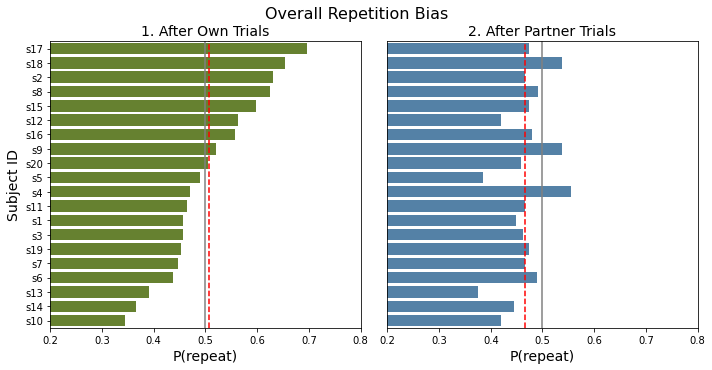

In [ ]:
#repetition bias for all subjects
plots = ['l1_pr_own','l1_pr_dyad']
plot_labels = {
    'l1_pr': "P(repeat) overall",
    'l1_pr_own': "After Own Trials",
    'l1_pr_dyad': "After Partner Trials"
    
}

tmpdf = individual_df.sort_values(by=plots[0], ascending=False)
tmpdf['subj_idx'].replace(sids,inplace=True) #change subject ids

do_nx2_plots(plots,plot_labels,"Overall Repetition Bias",tmpdf)

In [ ]:
ci = scipy.stats.bootstrap((individual_df['l1_pr_own'].to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=0.4664990153192443, high=0.5494618496356424)


In [ ]:
individual_df['l1_pr_own'].mean()

0.5061763741840026

In [ ]:
individual_df['l1_pr_own'].sem()

0.021817670707663474

**H0: There is no repetition bias after dyadic trials i.e. the p(repeat) after dyadic is 0.5**

In [ ]:
pr_diff_frm_5 = np.abs(individual_df['l1_pr_dyad'] - 0.5)
individual_df['l1_pr_dyad'].sem()

0.010198149350566333

In [ ]:
i=0
d = []
while i < 5000:
    #df = pr_diff_frm_5.sample(n=pr_diff_frm_5.shape[0],replace=True)
    df = individual_df['l1_pr_dyad'].sample(n=individual_df['l1_pr_dyad'].shape[0],replace=True)
    d.append(df.mean())      
    i += 1

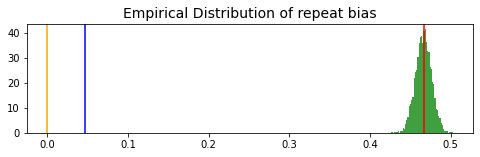

In [ ]:
fig, ax = plt.subplots(figsize=(8,2))
n, bins, patches = plt.hist(d, 50, density=True, facecolor='g', alpha=0.75)
plt.axvline(np.mean(d),color='red')
plt.axvline(pr_diff_frm_5.mean(),color='blue')
plt.axvline(0,color='orange')
plt.title("Empirical Distribution of repeat bias",fontsize=14)
plt.show()

In [ ]:
ci = scipy.stats.bootstrap((individual_df['l1_pr_dyad'].to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=0.4468150311178816, high=0.485529177500243)


Conlusion: Post dyadic trials there is a bias. The bias is towards alternation.

**H0: There is no difference in the p(repeat) after own trial and after partner trial**

In [ ]:
pr_diff = individual_df['l1_pr_own'] - individual_df['l1_pr_dyad']

In [ ]:
pr_diff.mean()

0.03978406950069888

In [ ]:
i=0
d1 = []
while i < 5000:
    df = pr_diff.sample(n=pr_diff.shape[0],replace=True)
    d1.append(df.mean())      
    i += 1

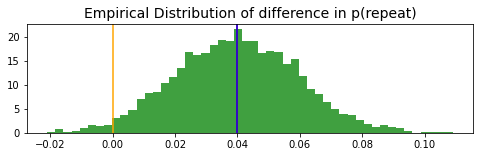

In [ ]:
fig, ax = plt.subplots(figsize=(8,2))
n, bins, patches = plt.hist(d1, 50, density=True, facecolor='g', alpha=0.75)
plt.axvline(np.mean(d1),color='red')
plt.axvline(pr_diff.mean(),color='blue')
plt.axvline(0,color='orange')
plt.title("Empirical Distribution of difference in p(repeat)",fontsize=14)
plt.show()

In [ ]:
ci = scipy.stats.bootstrap((pr_diff.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=0.003270096726415969, high=0.08112589929047602)


Conclusion: Choice bias after own and after partner trials are different. P(repeat) after own trial is higher, this dovetails with the previous finding that post dyadic trials there is an alternation bias.

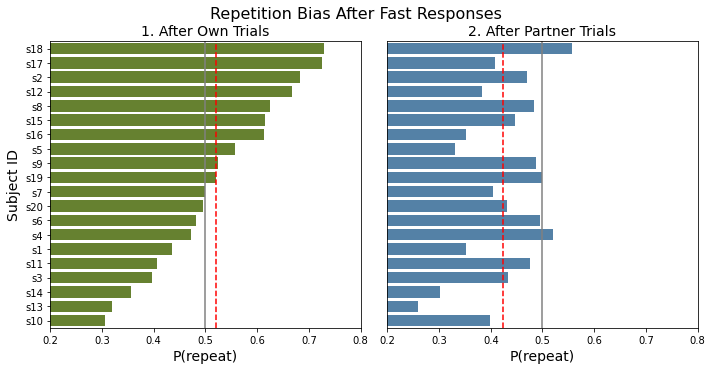

In [ ]:
#repetition bias for fast resposnes for all subjects
plots = ['l1_pr_fastRT_own','l1_pr_fastRT_dyad']
plot_labels = {
    'l1_pr_fastRT': "p(repeat) overall",
    'l1_pr_fastRT_own': "After Own Trials",
    'l1_pr_fastRT_dyad': "After Partner Trials"
    
}

tmpdf = individual_df.sort_values(by=plots[0], ascending=False)
tmpdf['subj_idx'].replace(sids,inplace=True) #change subject ids

do_nx2_plots(plots,plot_labels,"Repetition Bias After Fast Responses",tmpdf)

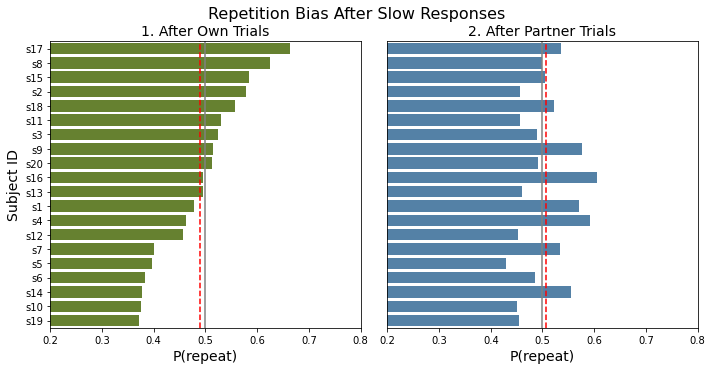

In [ ]:
#repetition bias for slow resposnes for all subjects
plots = ['l1_pr_slowRT_own','l1_pr_slowRT_dyad']
plot_labels = {
    'l1_pr_slowRT': "p(repeat) overall",
    'l1_pr_slowRT_own': "After Own Trials",
    'l1_pr_slowRT_dyad': "After Partner Trials"
    
}

tmpdf = individual_df.sort_values(by=plots[0], ascending=False)
tmpdf['subj_idx'].replace(sids,inplace=True) #change subject ids

do_nx2_plots(plots,plot_labels,"Repetition Bias After Slow Responses",tmpdf)

**H0: There is no difference in the p(repeat) after own trial between fast and slow responses**

In [ ]:
fastslow_diff = individual_df['l1_pr_slowRT_own'] - individual_df['l1_pr_fastRT_own']
print(fastslow_diff.mean())

-0.03224421241946759


In [ ]:
ci = scipy.stats.bootstrap((fastslow_diff.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=-0.07614534542935075, high=0.014496378048041648)


Null hypothesis retained.

**H0: There is no difference in the p(repeat) after partner's trial between fast and slow responses**

In [ ]:
dyadicfastslow_diff = individual_df['l1_pr_slowRT_dyad'] - individual_df['l1_pr_fastRT_dyad']
print(dyadicfastslow_diff.mean())

0.0815229828024474


In [ ]:
ci = scipy.stats.bootstrap((dyadicfastslow_diff.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=0.04575908654648443, high=0.12377827820573302)


**H0: There is no difference in the p(repeat) after slow responses between dyadic and non-dyadic condition**

In [ ]:
slow_diff = individual_df['l1_pr_slowRT_dyad'] - individual_df['l1_pr_slowRT_own']
slow_diff.mean()

0.016955218146758787

In [ ]:
ci = scipy.stats.bootstrap((slow_diff.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=-0.02460085021898526, high=0.05720312860986716)


**H0: There is no difference in the p(repeat) after fast responses between dyadic and non-dyadic condition**

In [ ]:
fast_diff = individual_df['l1_pr_fastRT_dyad'] - individual_df['l1_pr_fastRT_own']
fast_diff.mean()

-0.09681197707515618

In [ ]:
ci = scipy.stats.bootstrap((fast_diff.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=-0.1515278518587675, high=-0.046476229048456635)


**Analysis based on correctness of previous trial**

In [75]:
#probability of repeat after correct trails of own 
ci = scipy.stats.bootstrap((individual_df['l1_pr_post_corr_own'].to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=0.4492284380820796, high=0.5362702665437227)


In [76]:
#probability of repeat after correct trails of partner
ci = scipy.stats.bootstrap((individual_df['l1_pr_post_corr_dyad'].to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=0.4186177278387706, high=0.46645053459622887)


In [77]:
#probability of repeat after incorrect trails of partner
ci = scipy.stats.bootstrap((individual_df['l1_pr_post_err_dyad'].to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=0.5191789040739282, high=0.6091505791522039)


In [78]:
#probability of repeat after incorrect trails of own
ci = scipy.stats.bootstrap((individual_df['l1_pr_post_err_own'].to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=0.5245429593767892, high=0.6196564149215071)


In [79]:
#difference in probability of repeat after correct and incorrect trails of own
df = individual_df['l1_pr_post_err_own'] - individual_df['l1_pr_post_corr_own']
ci = scipy.stats.bootstrap((df.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=0.041790967352058214, high=0.13033233647164738)


In [81]:
#difference in probability of repeat after correct and incorrect trails of partner
df = individual_df['l1_pr_post_err_dyad'] - individual_df['l1_pr_post_corr_dyad']
ci = scipy.stats.bootstrap((df.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=0.07441656519480369, high=0.17754443191404526)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


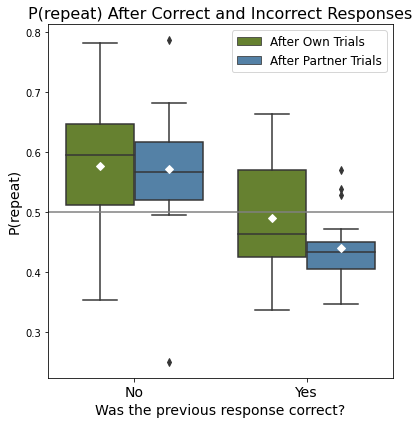

In [71]:
trials_df['prev_corr'] = 'Yes'
trials_df.loc[(trials_df['l1_stim'] != trials_df['l1_resp']),'prev_corr'] = 'No'
tmpdf = trials_df.groupby(['subj_idx','l1_subject','prev_corr'])['l1_repeat'].mean().reset_index()
tmpdf['l1_subject'] = np.select([(tmpdf['l1_subject'] == tmpdf['subj_idx']),(tmpdf['l1_subject'] != tmpdf['subj_idx'])],
                                ['After Own Trials','After Partner Trials'])


fig,ax = plt.subplots(figsize=(6,6))
my_palette = {"After Own Trials": "olivedrab", "After Partner Trials": "steelblue"}
sns.boxplot(data=tmpdf,y='l1_repeat',x='prev_corr',hue='l1_subject',palette=my_palette,
            showmeans=True,
            meanprops={"marker":"D",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"white",
                      "markersize":"5"},
            ax=ax)
ax.axhline(0.5,color='gray')
ax.set_title("P(repeat) After Correct and Incorrect Responses",fontsize=16)
ax.set_ylabel('P(repeat)',fontsize=14)
ax.set_xlabel('Was the previous response correct?',fontsize=14)
ax.tick_params(axis='x', which='major', labelsize=14)
ax.legend(title="",fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(plotfolder,"pr_corr_incorrect.eps"),dpi=1200)
plt.show()

In [12]:
table = pd.pivot_table(tmpdf,index=['subj_idx','l1_subject'],columns='prev_corr',values='l1_repeat')

In [13]:
df = table.loc[(slice(None),'After Own Trials'),'No'] - table.loc[(slice(None),'After Own Trials'),'Yes']
ci = scipy.stats.bootstrap((df.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=0.042713074014278186, high=0.13185149928861079)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


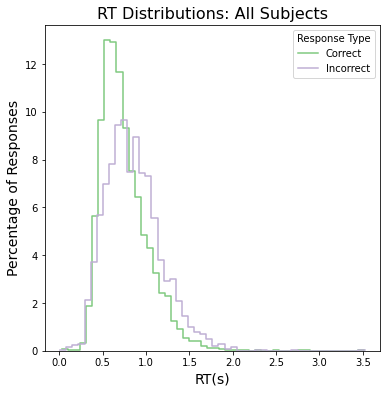

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
tmpdf = trials_df[['subj_idx','rt','correct']]
#tmpdf.loc[tmpdf['correct']==0,'rt'] = tmpdf['rt'] * -1
tmpdf.loc[tmpdf['correct']==1,'correct'] = 'Correct'
tmpdf.loc[tmpdf['correct']==0,'correct'] = 'Incorrect'
tmpdf.rename(columns={'correct':'Response Type'},inplace=True)

#sns.histplot(data=tmpdf,x='rt',hue='Response Type',stat='percent',bins=50,ax=ax,element='step',fill=False,palette="bright")
sns.histplot(data=tmpdf[tmpdf['Response Type']=='Correct'],x='rt',stat='percent',bins=50,ax=ax,element='step',fill=False,label='Correct')
sns.histplot(data=tmpdf[tmpdf['Response Type']=='Incorrect'],x='rt',stat='percent',bins=50,ax=ax,element='step',fill=False,label='Incorrect')
ax.set_xlabel('RT(s)',fontsize=14)
ax.set_ylabel('Percentage of Responses',fontsize=14)
ax.set_title('RT Distributions: All Subjects',fontsize=16)
ax.legend(title='Response Type')
plt.show()
del tmpdf


# GLM for Validation of Choice behaviour

In [14]:
def robust_z_score(df):
  median = df.median()
  df = df - median
  mad = 1.4296 * df.abs().median()
  df = df/mad
  return df

def fast_slow_coding(df):
  median = df.median()
  m1 = df > median
  m2 = df < median
  m3 = df == median
  df[m1] = -1
  df[m2] = 1
  df[m3] = 0

  return df

def fast_slow_coding_cat(df):
  median = df.median()
  m1 = df > median
  m2 = df < median
  m3 = df == median
  df[m1] = 'slow'
  df[m2] = 'fast'
  df[m3] = 'none'

  return df

In [ ]:
trials_df.columns

Index(['block', 'trial', 'direction', 'response', 'rt', 'subj_idx', 'correct',
       'l1_stim', 'l1_resp', 'l1_subject', 'l1_rt', 'l1_repeat', 'l2_stim',
       'l2_resp', 'l2_subject', 'l2_rt', 'l2_repeat', 'l3_stim', 'l3_resp',
       'l3_subject', 'l3_rt', 'l3_repeat', 'l4_stim', 'l4_resp', 'l4_subject',
       'l4_rt', 'l4_repeat', 'l5_stim', 'l5_resp', 'l5_subject', 'l5_rt',
       'l5_repeat', 'l6_stim', 'l6_resp', 'l6_subject', 'l6_rt', 'l6_repeat',
       'l7_stim', 'l7_resp', 'l7_subject', 'l7_rt', 'l7_repeat', 'l8_stim',
       'l8_resp', 'l8_subject', 'l8_rt', 'l8_repeat', 'l9_stim', 'l9_resp',
       'l9_subject', 'l9_rt', 'l9_repeat', 'l10_stim', 'l10_resp',
       'l10_subject', 'l10_rt', 'l10_repeat'],
      dtype='object')

In [15]:
model_data = trials_df[['subj_idx','direction', 'response','rt','l1_stim','l1_resp', 'l1_subject','l2_resp', 'l2_subject']]
model_data['l1_rt'] = model_data['rt'].shift(1) 
model_data.loc[model_data['response']==-1,'response'] = 'left'
model_data.loc[model_data['response']==1,'response'] = 'right'
model_data['l1_subject'] = np.select([(model_data['l1_subject'] == model_data['subj_idx']),(model_data['l1_subject'] != model_data['subj_idx'])],[1,-1])
model_data['l1_correct'] = np.select([(model_data['l1_stim'] == model_data['l1_resp']),(model_data['l1_stim'] != model_data['l1_resp'])],[1,-1])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [16]:
model_data.loc[:,'rt_type'] = model_data.loc[:,'l1_rt']
model_data.loc[:,'rt_cat'] = model_data.loc[:,'l1_rt']
for s in subjects:
  tmpdf = model_data.loc[model_data['subj_idx']==s,'l1_rt']
  model_data.loc[model_data['subj_idx']==s,'l1_rt'] = robust_z_score(tmpdf)
  tmpdf = model_data.loc[model_data['subj_idx']==s,'rt_type']
  model_data.loc[model_data['subj_idx']==s,'rt_type'] = fast_slow_coding(tmpdf)
  tmpdf = model_data.loc[model_data['subj_idx']==s,'rt_cat']
  model_data.loc[model_data['subj_idx']==s,'rt_cat'] = fast_slow_coding_cat(tmpdf)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [17]:
model_data

,subj_idx,direction,response,rt,l1_stim,l1_resp,l1_subject,l2_resp,l2_subject,l1_rt,l1_correct,rt_type,rt_cat
0,268006_2,-1,left,0.982014,NaN,NaN,-1,NaN,NaN,NaN,-1,NaN,NaN
1,268006_2,1,left,0.701318,-1.0,-1.0,1,NaN,NaN,1.221447,1,-1.0,slow
2,268006_2,1,right,0.875515,1.0,-1.0,1,-1.0,268006_2,-0.282594,-1,1.0,fast
3,268006_2,1,right,0.883835,1.0,1.0,1,-1.0,268006_2,0.650798,1,-1.0,slow
4,268006_2,1,right,1.138592,1.0,1.0,1,1.0,268006_2,0.695378,1,-1.0,slow
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9543,958733_2,-1,left,0.650772,-1.0,-1.0,-1,1.0,958733_2,-0.852875,1,1.0,fast
9544,958733_2,-1,right,0.848053,-1.0,-1.0,1,-1.0,958733_1,-0.381695,1,1.0,fast
9545,958733_1,-1,right,0.706652,-1.0,1.0,-1,-1.0,958733_2,0.472739,-1,-1.0,slow
9546,958733_1,1,right,1.768333,-1.0,1.0,1,1.0,958733_2,-0.219887,-1,1.0,fast


In [18]:
model_data.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**First model:**
P(right) depends only on current stimulus

regressors are:


1.   Current trial: stimulus
2.   Prev trial: None





In [20]:
model1 = bambi.Model("response['right'] ~ direction", model_data, family='bernoulli')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [21]:
result1 = model1.fit(draws=5000,chains=2)

Modeling the probability that response==right
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [direction, Intercept]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 50 seconds.


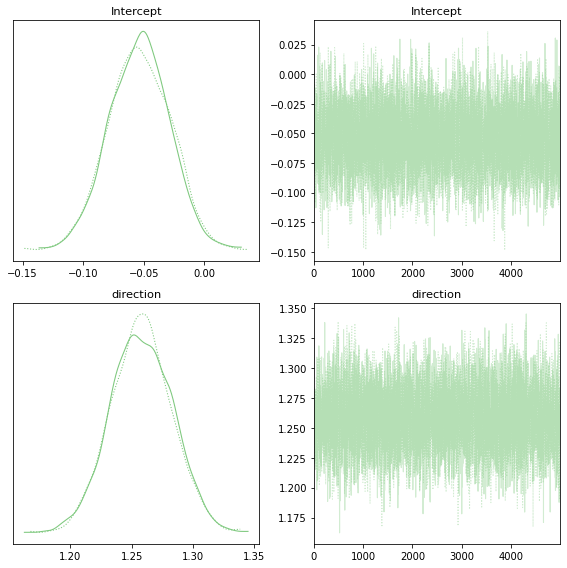

In [22]:
fig,axes = plt.subplots(2,2,figsize=(8,8))
az.plot_trace(result1,compact=True,axes=axes)
plt.tight_layout()
plt.show()

In [23]:
post_pred1 = model1.predict(result1, kind="pps", draws=100)

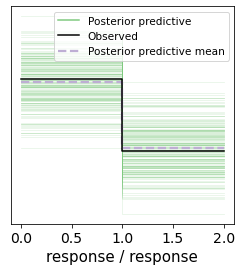

In [29]:
fig,axes = plt.subplots(figsize=(4,4))
az.plot_ppc(result1,ax=axes)
plt.show()

In [ ]:
az.summary(result1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.054,0.025,-0.102,-0.010,0.0,0.0,8726.0,7259.0,1.0
direction,1.259,0.026,1.212,1.308,0.0,0.0,9002.0,6823.0,1.0


**Second model:**
Does the response in previous trial have an impact

regressors are:


1.   Current trial: stimulus
2.   Prev trial: response


In [30]:
model2 = bambi.Model("response['right'] ~ direction + l1_resp", model_data, family='bernoulli')


In [31]:
result2 = model2.fit(draws=5000,chains=2)

Modeling the probability that response==right
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [l1_resp, direction, Intercept]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 74 seconds.


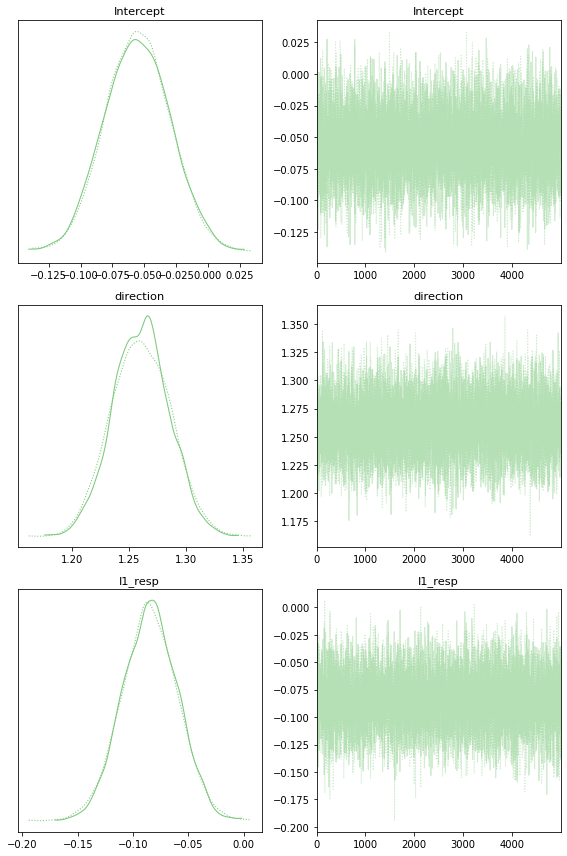

In [32]:
fig,axes = plt.subplots(3,2,figsize=(8,12))
az.plot_trace(result2,compact=True,axes=axes)
plt.tight_layout()
plt.show()

In [33]:
post_pred2 = model2.predict(result2, kind="pps", draws=100)

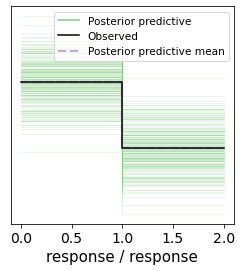

In [34]:
fig,axes = plt.subplots(figsize=(4,4))
az.plot_ppc(result2,ax=axes)
plt.show()

In [35]:
az.summary(result2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.055,0.026,-0.103,-0.007,0.0,0.0,14530.0,7520.0,1.0
direction,1.261,0.025,1.214,1.308,0.0,0.0,13232.0,7676.0,1.0
l1_resp,-0.085,0.025,-0.131,-0.037,0.0,0.0,12598.0,7472.0,1.0


**Third model:**
Tests impact of who did the previpis trial

regressors are:


1.   Current trial: stimulus
2.   Prev trial: response, subject and their interactions 

In [36]:
model3 = bambi.Model("response['right'] ~ direction + l1_resp + l1_subject + l1_resp:l1_subject", model_data, family='bernoulli')

In [37]:
result3 = model3.fit(draws=5000,chains=2)

Modeling the probability that response==right
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [l1_resp:l1_subject, l1_subject, l1_resp, direction, Intercept]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 92 seconds.


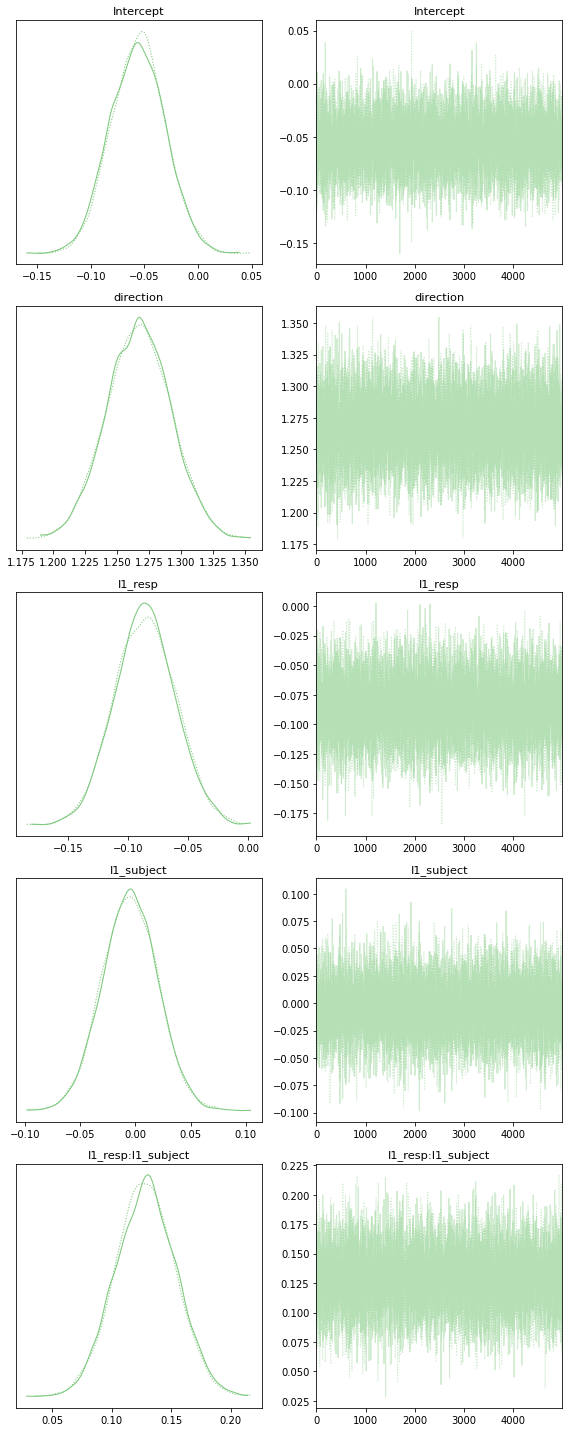

In [38]:
fig,axes = plt.subplots(5,2,figsize=(8,20))
az.plot_trace(result3,compact=True,axes=axes)
plt.tight_layout()
plt.show()

In [39]:
post_pred3 = model3.predict(result3, kind="pps", draws=100)

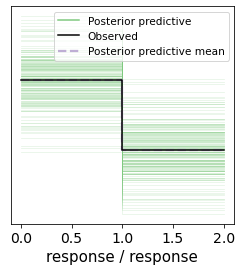

In [40]:
fig,axes = plt.subplots(figsize=(4,4))
az.plot_ppc(result3,ax=axes)
plt.show()

In [42]:
az.summary(result3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.056,0.025,-0.103,-0.009,0.0,0.0,17346.0,7940.0,1.0
direction,1.267,0.025,1.218,1.312,0.0,0.0,18299.0,8416.0,1.0
l1_resp,-0.086,0.025,-0.132,-0.037,0.0,0.0,19152.0,8059.0,1.0
l1_subject,-0.005,0.025,-0.052,0.042,0.0,0.0,18566.0,7889.0,1.0
l1_resp:l1_subject,0.129,0.025,0.081,0.175,0.0,0.0,15216.0,7508.0,1.0


Fourth model: Tests impact of who did the previous trial

regressors are:

    Current trial: stimulus
    Prev trial: response, subject, correctness and their interactions

In [44]:
model4 = bambi.Model("response['right'] ~ direction + l1_resp + l1_subject + l1_correct + l1_resp:l1_subject + l1_correct:l1_subject + l1_resp:l1_correct", model_data, family='bernoulli')
result4 = model4.fit(draws=5000,chains=2)

Modeling the probability that response==right
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [l1_resp:l1_correct, l1_correct:l1_subject, l1_resp:l1_subject, l1_correct, l1_subject, l1_resp, direction, Intercept]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 151 seconds.


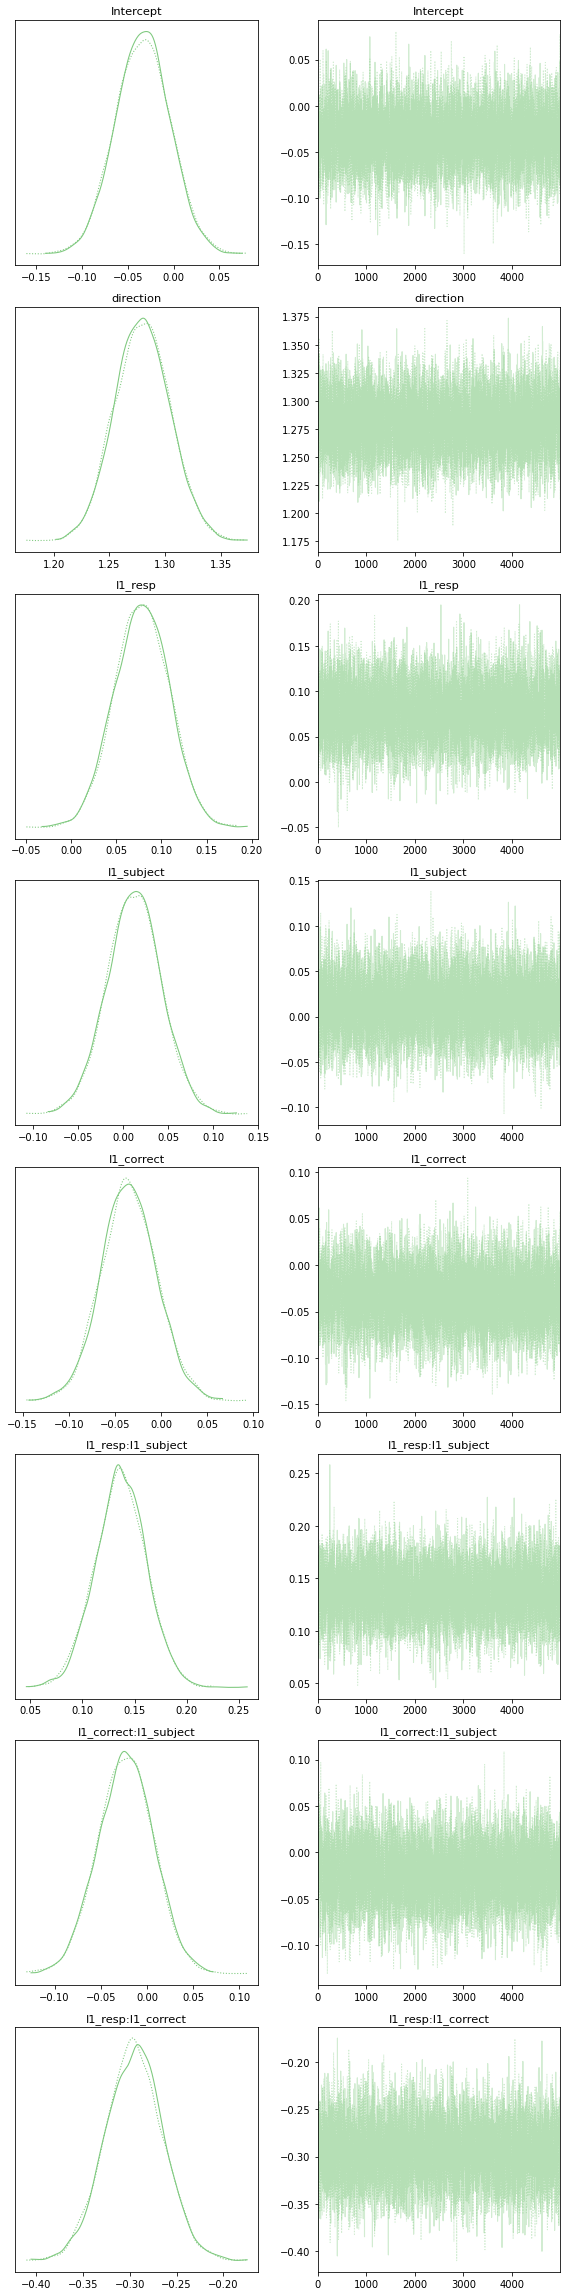

In [51]:
fig,axes = plt.subplots(8,2,figsize=(8,32))
az.plot_trace(result4,compact=True,axes=axes)
plt.tight_layout()
plt.show()

In [52]:
post_pred4 = model4.predict(result4, kind="pps", draws=100)

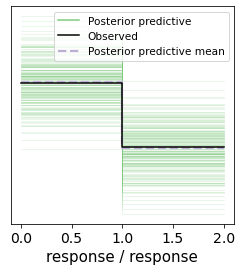

In [54]:
fig,axes = plt.subplots(figsize=(4,4))
az.plot_ppc(result4,ax=axes)
plt.show()

In [69]:
az.summary(result4,hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.034,0.030,-0.081,0.013,0.0,0.0,11279.0,7603.0,1.0
direction,1.280,0.025,1.240,1.318,0.0,0.0,12038.0,8051.0,1.0
l1_resp,0.078,0.030,0.029,0.125,0.0,0.0,10461.0,8079.0,1.0
l1_subject,0.012,0.030,-0.037,0.060,0.0,0.0,10909.0,8509.0,1.0
l1_correct,-0.034,0.030,-0.082,0.013,0.0,0.0,11996.0,7840.0,1.0
l1_resp:l1_subject,0.137,0.025,0.098,0.177,0.0,0.0,11336.0,7975.0,1.0
l1_correct:l1_subject,-0.023,0.030,-0.071,0.026,0.0,0.0,11090.0,8130.0,1.0
l1_resp:l1_correct,-0.295,0.031,-0.343,-0.245,0.0,0.0,10507.0,7939.0,1.0


In [63]:
models_dict = {
    "No History": result1,
    "Response": result2,
    "Response + Subject": result3,
    "Response + Subject + Correctness": result4
}
df_compare = az.compare(models_dict)


                                  rank          loo  ...  warning  loo_scale
Response + Subject + Correctness     0 -4894.587005  ...    False        log
Response + Subject                   1 -4939.692481  ...    False        log
Response                             2 -4951.022562  ...    False        log
NoHistory                            3 -4955.758878  ...    False        log

[4 rows x 9 columns]


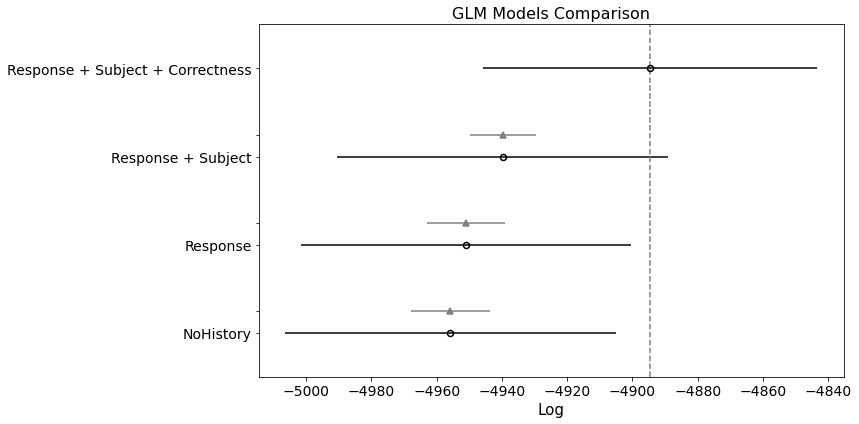

In [68]:
print(df_compare)
fig,axes = plt.subplots(figsize=(12,6))
az.plot_compare(df_compare, insample_dev=False,ax=axes)
axes.set_title("GLM Models Comparison",fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(plotfolder,"GLMComparison.eps"),dpi=1200)
plt.show()

the model encompassing all the effects we saw does explain the data better.

#Part B: What explains these choice repetiion behaviours?

Following Urai (2019) comparison is done between:
1. DDM with both drift-rate and starting-point depending on responseof the previous trial <- the conclusion in Urai (2019)
2. DDM with both drift-rate and starting-point depending on response of the previous trial as well as who did the previous trial own/partner

Further to Urai(2019): when the drift-rate and starting-point both vary depending on the previous response as well as the identity of the respondent (self/dyad) describes the observed data better

SpearmanrResult(correlation=0.9759398496240601, pvalue=2.3519202099227064e-13)


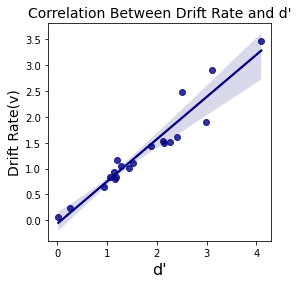

In [ ]:
#Check that the drift rate and dprimes are correlated or not
fig,ax = plt.subplots(figsize=(4,4))
x = individual_df['dprime']
y = individual_df['v']
res= scipy.stats.spearmanr(x, y)
print(res)
if res.pvalue < 0.05:
    sns.regplot(x=x, y=y, ax=ax,marker='o',color='navy')
else:
    sns.scatterplot(x=x, y=y, ax=ax,color='lightcoral')

ax.set_title("Correlation Between Drift Rate and d'".format(res.correlation,res.pvalue),fontsize=14)
ax.set_ylabel("Drift Rate(v)",fontsize=14)
ax.set_xlabel("d'",fontsize=16)
plt.show()



In [ ]:
#check the RT plots from PPC
ppc = pd.read_csv("drive/MyDrive/DDM_SP_2021-22/data/output/stimcoding_dc_z_resp_dyadic_l1/ppc_data_smallsample.csv",index_col=0)

In [ ]:
print(ppc.shape)
ppc = ppc[['rt_sampled','response_sampled','direction','rt']]
ppc.loc[ppc['rt_sampled'] < 0,'rt_sampled'] = ppc.loc[ppc['rt_sampled'] < 0,'rt_sampled'] * -1
ppc.loc[ppc['rt'] < 0,'rt'] = ppc.loc[ppc['rt'] < 0,'rt'] * -1

(473150, 4)


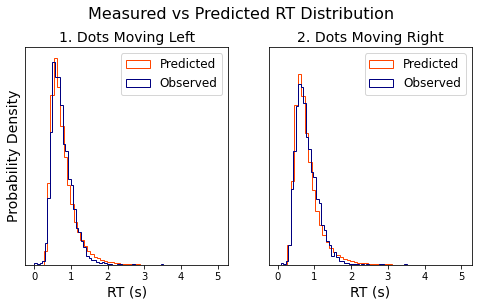

In [ ]:
#for i in [0,1]:
#sns.histplot(data=ppc[ppc['direction']==0],x='rt_sampled',hue='response_sampled',stat='frequency',bins=10,ax=ax,element='step',fill=False,palette="bright")
fig, ax = plt.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)
ax[0].hist(ppc.loc[(ppc['direction']==0),'rt_sampled'],bins=50,histtype='step',fill=None,density=True,color='orangered',label="Predicted")
ax[0].hist(ppc.loc[(ppc['direction']==0),'rt'],bins=50,histtype='step',fill=None,density=True,color='navy',label="Observed")
ax[1].hist(ppc.loc[(ppc['direction']==1),'rt_sampled'],bins=50,histtype='step',fill=None,density=True,color='orangered',label="Predicted")
ax[1].hist(ppc.loc[(ppc['direction']==1),'rt'],bins=50,histtype='step',fill=None,density=True,color='navy',label="Observed")
ax[0].set_ylabel('Probability Density',fontsize=14)
ax[0].set_yticks([])
ax[0].set_xlabel("RT (s)",fontsize=14)
ax[1].set_xlabel("RT (s)",fontsize=14)
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
ax[1].legend(fontsize=12)

fig.suptitle("Measured vs Predicted RT Distribution",fontsize=16,y=1.02)
ax[0].set_title("{}. {}".format(1,"Dots Moving Left"),fontsize=14)
ax[1].set_title("{}. {}".format(2,"Dots Moving Right"),fontsize=14)

plt.show()


Comparison of all the HDDM models

In [ ]:
outputsrc = "drive/MyDrive/DDM_SP_2021-22/data/output"
model_comparison = "model_comparison.csv"
base_model= "stimcoding_nohist"
models= {
    'non-dyadic_both': "stimcoding_dc_z_resp_l1",
    'dyadic_both': "stimcoding_dc_z_resp_dyadic_l1",
    'dyadic_dc': "stimcoding_dc_resp_dyadic_l1",
    'dyadic_z': "stimcoding_z_resp_dyadic_l1"
}
tmpdf = pd.read_csv(os.path.join(outputsrc,base_model,model_comparison))
base_aic = tmpdf['aic'].item()
aic_values = {}
for m in models.keys():
  fpath = os.path.join(outputsrc,models[m],model_comparison)
  tmpdf = pd.read_csv(fpath)
  aic_values[m] = tmpdf['aic'].item() 

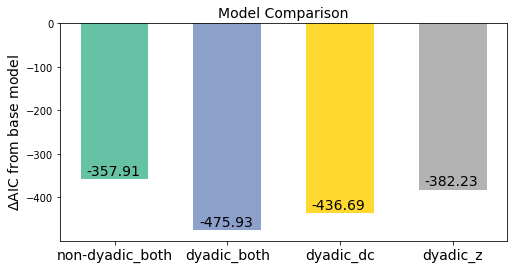

In [ ]:
plots = list(models.keys())
aic_differences = [aic_values[m] - base_aic for m in plots]
cm = plt.cm.get_cmap('Set2', len(plots))
fig,ax = plt.subplots(figsize=(8,4))
ax.bar(x=plots, 
       height=aic_differences,
       width=0.6,
       color=[cm(i) for i in range(len(plots))])
for i, v in enumerate(aic_differences):
    ax.text(i - 0.25, v + 10, "{:6.2f}".format(v), color='black', fontsize=14) #show the values
ax.set_ylabel(r'$\Delta$' + 'AIC from base model',fontsize=14)
ax.set_title("Model Comparison",fontsize=14)
ax.tick_params(axis='x',which='major',labelsize=14)
plt.show()

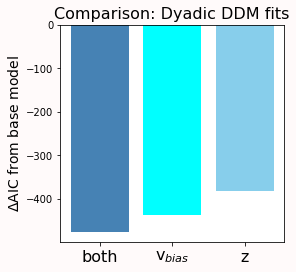

In [ ]:
plots = ['dyadic','dyadic_dc','dyadic_z']
fig,ax = plt.subplots(figsize=(4,4),facecolor='snow')
ax.bar(x=plots, 
       height=[aic_values[plots[0]] - base_aic ,aic_values[plots[1]] - base_aic,aic_values[plots[2]] - base_aic,],
       color=['steelblue','cyan','skyblue'] )
ax.set_xticklabels(['both',r'v$_{bias}$','z'],fontsize=16)
ax.set_ylabel(r'$\Delta$' + 'AIC from base model',fontsize=14)
ax.set_title("Comparison: Dyadic DDM fits",fontsize=16)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


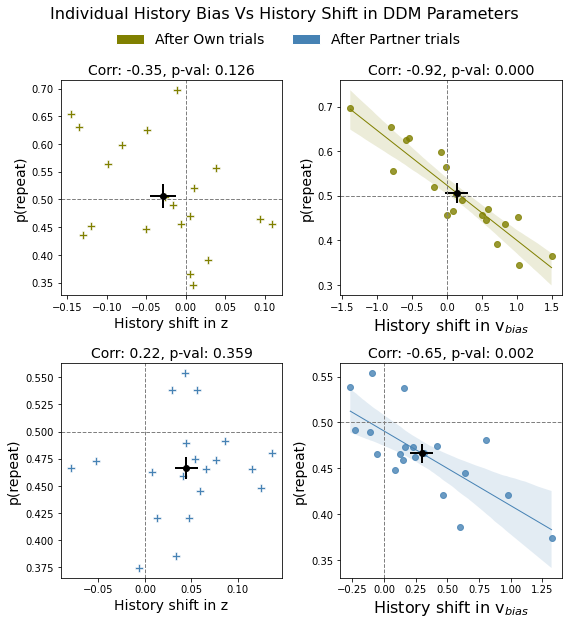

In [82]:
def format_plot(x,y,ax,feature='z',cond='own'):
  color = 'olive' if cond=='own' else 'steelblue'
  label = 'Own' if cond=='own' else 'Dyadic'
  marker = 'P' if feature == 'z' else 'o'
  res= scipy.stats.spearmanr(x, y)
  if res.pvalue < 0.05:
    sns.regplot(x=x, y=y, ax=ax,marker=marker,color=color,line_kws={'linewidth':1})
  else:
    sns.scatterplot(x=x,y=y,ax=ax,marker=marker,color=color,s=60)
  
  ax.errorbar(x=x.mean(), y=y.mean(), xerr=scipy.stats.sem(x), yerr=scipy.stats.sem(y), capsize=None, color='black', alpha=1, linewidth=2, linestyle='', marker='o')
  ax.set_title("Corr: {:3.2f}, p-val: {:4.3f}".format(res.correlation,res.pvalue),fontsize=14)
  ax.axvline(0,color='gray',linewidth=1,linestyle='--')
  ax.axhline(0.5,color='gray',linewidth=1,linestyle='--')
  ax.set_ylabel("p(repeat)",fontsize=14)
  if feature == 'z':
    ax.set_xlabel("History shift in z",fontsize=14)
  else:
    ax.set_xlabel(r"History shift in v$_{bias}$",fontsize=16)



fig,ax = plt.subplots(2,2,figsize=(8,8))
ax = ax.flatten()
format_plot(individual_df['z_shift_own'], individual_df['l1_pr_own'],ax[0],'z')
format_plot(individual_df['v_shift_own'], individual_df['l1_pr_own'],ax[1],r"v$_{bias}$")
format_plot(individual_df['z_shift_dyad'], individual_df['l1_pr_dyad'],ax[2],'z','dyad')
format_plot(individual_df['v_shift_dyad'], individual_df['l1_pr_dyad'],ax[3],r"v$_{bias}$",'dyad')
fig.suptitle("Individual History Bias Vs History Shift in DDM Parameters",fontsize=16,y=1.08)
legend_elements = [matplotlib.patches.Patch(facecolor='olive', edgecolor='w',label='After Own trials'),
                   matplotlib.patches.Patch(facecolor='steelblue', edgecolor='w',label='After Partner trials')]
fig.legend(handles=legend_elements,ncol=len(legend_elements),bbox_to_anchor=(0., 1.025, 1.0, 0.025),loc='upper center',fontsize=14,framealpha=0)
plt.tight_layout()
plt.savefig(os.path.join(plotfolder,"historyshift.eps"),dpi=1200)
plt.show()


# Exploratory: Does own behavior depend on partner's accuracy?

In [ ]:
prepeat = individual_df["l1_pr_dyad"] # p repeat after partner trials
temp = list(individual_df["accuracy"])
i = np.linspace(0,18,num=10, dtype=int)
accuracies = [] # accuracy of the respective partner
for idx in i:
    accuracies.append(temp[idx+1])
    accuracies.append(temp[idx])

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
x = prepeat
y = accuracies
res = scipy.stats.spearmanr(x, y)
print(res)
if res.pvalue < 0.05:
    sns.regplot(x=x, y=y, ax=ax,marker='o',color='navy')
else:
    sns.scatterplot(x=x, y=y, ax=ax,color='lightcoral')

ax.set_title("Correlation Between Own Behavior\nand Partner's Accuracy", fontsize=14, pad=20)
ax.set_ylabel("Partner Accuracy",fontsize=14)
ax.set_xlabel("P(repeat) after partner trials",fontsize=16)
plt.show()

In [ ]:
# color dots based on p(repeat) after own trials

from mpl_toolkits.axes_grid1 import make_axes_locatable

ax = plt.subplot()
temp = ax.scatter(x, y,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=individual_df["l1_pr_own"])

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(temp, cax=cax)

ax.set_title("Correlation Between Own Behavior\nand Partner's Accuracy", fontsize=14, pad=10)
ax.set_ylabel("Partner Accuracy",fontsize=14)
ax.set_xlabel("P(repeat) after partner trials",fontsize=16)

plt.show()